In [1]:
# import torch
# import os

# runs = os.listdir('saves')

# casename = runs[-1]

# print('=== === loading case ' + casename)

# saveDir = os.path.join('saves', casename)

# model = torch.load(os.path.join(saveDir, 'Original.pt'),map_location=torch.device('cpu'))

# history = torch.load(os.path.join(saveDir, 'History.pt'),map_location=torch.device('cpu'))

# selectStateDict = torch.load(os.path.join(
#     saveDir, history['saveNames'][-1]),map_location=torch.device('cpu'))

# model.load_state_dict(selectStateDict)

# model.eval()



=== === loading case 1639537706_21764


gradientGenA(
  (bndC2): Conv2d(3, 4, kernel_size=(2, 2), stride=(1, 1))
  (rhoC1): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1))
  (Bseq0): Sequential(
    (BLK0): gGABlockA(
      (convA): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (convB1): Conv2d(8, 48, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (convB2): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (poolA): AvgPool2d(kernel_size=3, stride=1, padding=1)
      (poolConv): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
      (act): Tanh()
    )
    (BLK1): gGABlockA(
      (convA): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (convB1): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (convB2): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=reflect)
      (poolA): AvgPool2d(kernel_size=

119003.99462749042 tensor([85033.9688, 60112.2617]) 60112.25774662299


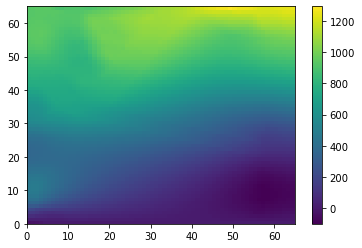

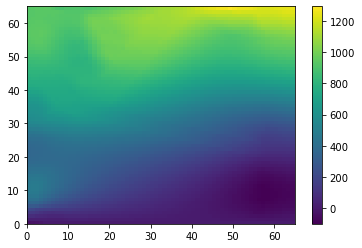

In [11]:
import femGTopo
import numpy
import numpy.linalg
import matplotlib.pyplot as plt
import numpy as np
import femDataGen
import femRandInput
import time,os
import torch
import dataReader

# generator = femDataGen.femDataGenFilterCut(nx=64, ny=64) 

# generator.loadData('data/recv', seqTarget=0)
# case = generator.getOneCase(1,4,useda=False)

torch.manual_seed(125)
reader = dataReader.Reader(2, preserve=['bnd', 'rho', 'res', 'PI_AB'],
                device='cpu')
reader.ReadFile('./data/test_optTrain', 0)
reader.state = 'train'
i = 0
readerIter = iter(reader)
batch = readerIter.__next__()
case = {}
selectCase = 1
case['fix'] = batch['bnd'][selectCase, 0 , :, :].to('cpu').numpy()
case['fx'] = batch['bnd'][selectCase, 1, :, :].to('cpu').numpy()
case['fy'] = batch['bnd'][selectCase, 2, :, :].to('cpu').numpy()
case['rho'] = batch['rho'][selectCase, 0, :, :].to('cpu').numpy()

Nx = 64
Ny = 64

fem = femGTopo.isoGridFem2DOptFun(1000,Nx,Ny,1,1)
fem.SetElemMat(4,4,1,0.3)

fix = numpy.zeros((Ny+1,Nx+1))
fx = numpy.zeros_like(fix)
fy = numpy.zeros_like(fix)
fix *= numpy.nan
fix[case['fix'] == 1.0] = 0.0
fx=case['fx']
fy=case['fy']

# fix[((fem.xm - 5)**2 + (fem.ym - 1)**2) <= 0.6012 ** 2] = 0.0001
rho = numpy.ones((Ny, Nx)) * 0.3
# rho[((fem.xcm - 5)**2 + (fem.ycm - 1)**2) <= 0.6012 **2] = 0
rho = case['rho']

fem.setBCs(fix, fx, fy)
fem.AssembleKbLocal()


fem.EvalVM(rho, False, True)
fem.EvalVMdiff(rho, False, False, False)
print(fem.PI_AB, batch['PI_AB'], (fem.fx * fem.uarray + fem.fy*fem.varray).sum())

plt.figure('ref')
plt.pcolor(fem.uarray)
plt.colorbar()



plt.figure('data')
plt.pcolor(batch['res'][selectCase,0,:,:])
plt.colorbar()


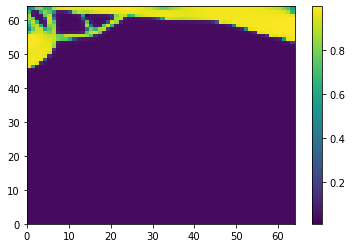

In [8]:
fixV = numpy.zeros_like(fix)
fixV[numpy.logical_not(numpy.isnan(fix))] = 1.0
bndV = numpy.concatenate((numpy.expand_dims(fixV, 0),
    numpy.expand_dims(fx, 0),
    numpy.expand_dims(fy, 0)))

bndNN = torch.tensor(bndV,dtype=torch.float).permute(0,2,1).unsqueeze(0)
rhoNN = torch.tensor(rho,dtype=torch.float).unsqueeze(0).permute(0,2,1).unsqueeze(0)
daNN = model(bndNN,rhoNN)
plt.figure('ref')
plt.pcolor(rhoNN.squeeze().detach().numpy())
plt.colorbar()